# DSO 530 Project

In [1]:
import math
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import time
import os

from glob import glob
from datetime import date, datetime, time, timedelta
from matplotlib import pyplot as plt
from pylab import rcParams
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from tqdm import tqdm_notebook

%matplotlib inline

#### Input params ##################
rawpath = './raw data 17-19/'
featurepath = './engineered features 17-19/'
cv_size = 0.3                   # proportion of dataset to be used as cross-validation set
#Nmax = 15                       # for feature at day t, we use lags from t-1, t-2, ..., t-N as features
                                # Nmax is the maximum N we are going to test
obs_per_reg = 15
# Number of training observations per regressor variable
fontsize = 14
ticklabelsize = 14
####################################

## Functions

In [2]:
#setting list of explanatory variables

regressors = ['volumelag', 'rsilag', 'fastKlag', 'fastDlag', 'ADlag',
             'OBVlag', 'MA5lag', 'MA15lag', 'day5Returnlag', 'day15Returnlag', 'PROClag', 'ma5_return', 
             'ma15_return', 'mstd5_return', 'mstd15_return', 'ma_dir_flag']

In [3]:
def get_preds_lin_reg(df, target_col, N, offset, forecast):
    """
    Given a dataframe, get prediction at timestep t using values from t-1, t-2, ..., t-N.
    Inputs
        df         : dataframe with the values you want to predict. Can be of any length.
        target_col : name of the column you want to predict e.g. 'close'
        N          : get prediction at timestep t using values from t-1, t-2, ..., t-N
        pred_min   : all predictions should be >= pred_min
        offset     : for df we only do predictions for df[offset:]. e.g. offset can be size of training set
    Outputs
        pred_list  : the predictions for target_col. np.array of length len(df)-offset.
    """
    # Create linear regression object
    regr = LinearRegression(fit_intercept=True)

    pred_list = []
    
    for i in range(offset, len(df['close'])-1):
        X_train = df.loc[i-N:i-1, regressors].values
        y_train = df.loc[i-N:i-1, target_col].values
        # X_train = np.c_[np.ones(N), X_train]              # add a column
        y_train = y_train.reshape(-1, 1)
        X_test = df.loc[i, regressors].values.reshape(1,-1)
        y_test = np.array(df.loc[i+(forecast-1), target_col])
    #     print X_train.shape
    #     print y_train.shape
    #     print 'X_train = \n' + str(X_train)
    #     print 'y_train = \n' + str(y_train)
        regr.fit(X_train, y_train)            # Train the model
        pred = regr.predict(X_test)
    
        pred_list.append(pred)  # Predict the footfall using the model
    
    pred_list.append(np.array([np.nan]))
    
    # If the values are < pred_min, set it to be pred_min
    pred_list = np.array(pred_list)
    #pred_list[pred_list < pred_min] = pred_min
        
    return pred_list

def get_mape(y_true, y_pred): 
    """
    Compute mean absolute percentage error (MAPE)
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
# A function to get the best training period for each stock 


#def get_best_N(mapeList, threshold = 0.03): 
    '''
    inputs
    mapeList : a list of mean absolute percentage errors, index 0 is where N = 2
    threshold : the threshold for how close the mape must be for N to be considered
    outputs:
    bestN : the maximum N that generates a mape as close as possible to the minimum
    '''
#    min_mape = min(mapeList)
#    arr = np.array(mapeList)
#    arr = arr[arr < min_mape + threshold]
#    best_N = mapeList.index(arr[-1]) + 2
#    return(best_N)


In [4]:
# Predictor gets dataset and returns the trading dataset
def predictor(df, cv_size = 0.3, forecast = 1, start_day = 505):
    '''
    Splits data into training, testing, and validation sets, 
    then returns a test set with 
    Inputs:
    df: dataframe with time series stock prices
    cv_size: desired size of cross-validation set
    forecast: the number of days in advance to forecast
    '''
    # Split into train, cv, and test
    trade_start = df.index[df['day'] == start_day][0]
    cv_start = int((1-cv_size)*trade_start)
    test = df[trade_start:].copy()
    train = df[:cv_start].copy()
    cv = df[cv_start:trade_start].copy()
    train_cv = df[:trade_start].copy()
    # Saving Lengths of the dataframes for future use
    num_cv = len(cv)
    num_test = len(test)
    num_train = len(train)
    #Finding MAPE
    #MAPE = []
    forecast = 1
    #for N in  range(2, Nmax):
    #    est_list = get_preds_lin_reg(train_cv, '1day_return', N, num_train, forecast)
    #    cv.loc[:, 'est_1day_return'] = est_list
    #    cv['pred'] = np.nan
    #    for i in range(cv_start+1, cv_start + len(cv)):
    #        cv.loc[i, 'pred'] = est_list[i-cv_start-1]
    #    cv.loc[cv_start,'pred'] = cv.loc[cv_start,'1day_return']
    #    MAPE.append(get_mape(cv['PROClag'], cv['pred']))
    
    #N = get_best_N(MAPE)
    N = len(regressors) * obs_per_reg
    # Making Predictions for training set
    #est_list = get_preds_lin_reg(train_cv, '1day_return_lag', N, num_train, forecast)
    #cv.loc[:, 'est_1day_return_lag'] = est_list
    #cv['pred'] = np.nan
    #for i in range(cv_start+1, cv_start + len(cv)):
    #    cv.loc[i, 'pred'] = est_list[i-cv_start-1]
    #cv.loc[cv_start,'pred'] = cv.loc[cv_start,'1day_return_lag']
    # Getting Validation Error Metrics
    #r2_val = r2_score(cv['close'], cv['pred'])
    #rmse_val = math.sqrt(mean_squared_error(cv['close'], cv['pred'],))
    #mape_val = get_mape(cv['close'], cv['pred'])
    
    # Making Predictions for test set
    est_list = get_preds_lin_reg(df, '1day_return_lag', N, num_train + num_cv, forecast)
    test.loc[:, 'est_1day_return_lag'] = est_list
    #test['pred'] = np.nan
    #for i in range(trade_start+1, trade_start + len(test)):
    #    test.loc[i, 'pred'] = est_list[i-trade_start-1]
    #test.loc[trade_start,'pred'] = test.loc[trade_start,'1day_return_lag']
    #r2_test = r2_score(cv['close'], cv['pred'])
    #rmse_test = math.sqrt(mean_squared_error(cv['close'], cv['pred'],))
    #mape_test = get_mape(cv['close'], cv['pred'])
    return(test.reset_index(drop = True))

In [5]:
# defining function to load in data and create variables

def merger(rawpath, featurepath, file, training_period = (len(regressors) * obs_per_reg), tech_start = 16):
    """
    Takes raw stock data and engineered features and
    returns a dataframe with new engineered variables
    """
    raw = pd.read_csv(rawpath + file).assign(filename=file)
    raw['day'] = raw.index + 1
    oneday_return_lag_list = [((raw['Close'][i] - raw['Close'][i-1]) / raw['Close'][i-1])*100 for i in range(1,len(raw))]
    raw['1day_return_lag'] = np.append(oneday_return_lag_list, np.array([np.nan]))
    MA5_return_list = [np.mean(oneday_return_lag_list[i-5:i]) for i in range(5, len(oneday_return_lag_list))]
    raw['MA5_return'] = np.append(np.append(np.array([np.nan, np.nan, np.nan, np.nan, np.nan]), MA5_return_list), np.array(np.nan))
    MA15_return_list = [np.mean(oneday_return_lag_list[i-15:i]) for i in range(15, len(oneday_return_lag_list))]
    raw['MA15_return'] = np.append(np.append(np.array([np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan]), MA15_return_list), np.array([np.nan]))
    MStd5_return_list = [np.std(oneday_return_lag_list[i-5:i]) for i in range(5, len(oneday_return_lag_list))]
    raw['MSTD5_return'] = np.append(np.append(np.array([np.nan, np.nan, np.nan, np.nan, np.nan]), MStd5_return_list), np.array(np.nan))
    MStd15_return_list = [np.std(oneday_return_lag_list[i-15:i]) for i in range(15, len(oneday_return_lag_list))]
    raw['MSTD15_return'] = np.append(np.append(np.array([np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan]), MStd15_return_list), np.array([np.nan]))
    raw['MA_dir_flag'] = np.where(np.sign(raw['MA5_return'])==np.sign(raw['MA15_return']), 1, 0)
    raw.columns = [str(x).lower().replace(' ', '_') for x in raw.columns]
    features = pd.read_csv(featurepath + file)
    featureCols = list(features.columns)
    featureCols[0] = 'time'
    features.columns = featureCols
    data = pd.merge(raw, features, on='time', how='outer')
    data['std_10PROClag'] = np.nan
    for i in range(tech_start + training_period, len(data)):
        std = data.loc[i-training_period:i-1, 'PROClag'].std()
        data.loc[i, 'std_10PROClag'] = std
    #data = data.iloc[16:, ].reset_index(drop = True)
    #cols = ['day','filename', 'PROClag', 'std_10PROClag', 'volume', 'close']
    return(data)


In [6]:
# Defining get metric function
def getMetric(df, day):
    '''
    gets the desired metric on a specified day
    '''
#    proj_return = (df.loc[day, 'est_2day'] - df.loc[day, 'close'])/\
#    df.loc[day, 'close']
    #metric = proj_return/(df.loc[day, 'std_10PROClag'])
    metric = df.loc[day, 'est_1day_return_lag']
    return(metric)

In [7]:
def trade(day, cash, increment, threshold, trade_data, 
          holding, cost , sell_thresh = -1.00):
    """
    Trades on a specific day given a starting amount of cash,
    A buying increment,
    A metric threshold,
    The day, and the dictionary of stock dataframes,
    And a dictionary of stocks held
    Inputs
    day: desired trading day
    cash: current cash level
    increment: how much cash to invest each day
    treshold: threshold for the chosen metric
    trade_data: dictionary of dataframes
    holding: dictionary of holdings for each stock
    """
    metricDF = pd.DataFrame(columns=['stock', 'metric'])
    for stock, df in trade_data.items():
        metric = getMetric(df, day)
        metricDF = metricDF.append({'stock': stock,
                                    'metric': metric}, ignore_index=True)
    metricDF = metricDF.sort_values(by='metric', ascending=False).reset_index(drop=True)
   
    # Defining Stocks that meet Sell Condition
    
    buyDF = metricDF[metricDF['metric'] > threshold+(cost*2)]
    sellDF = metricDF[metricDF['metric'] < sell_thresh]
    
    for stock in sellDF['stock']:
        price = trade_data[stock].loc[day, 'close']
        shares = holding[stock]
        cash += shares * price*(1-cost/100)
        holding[stock] = 0
        
     # choosing Stocks to buy
    
    for stock in buyDF['stock']:
        if holding[stock] == 0:
            price = trade_data[stock].loc[day, 'close']
            shares = min(increment, cash)/price
            holding[stock] += shares
            cash -= shares*price*(1+cost/100)
            
    return(cash, holding)

## Loading Data

In [11]:
raw_path = './raw data 17-19/'
eng_path = './engineered features 17-19/'

In [12]:
# First Stock
# Combining Raw files and engineered features
doc = 'SH600000.csv'
raw = pd.read_csv(raw_path + doc)
raw['day'] = raw.index + 1
oneday_return_lag_list = [((raw['Close'][i] - raw['Close'][i-1]) / raw['Close'][i-1])*100 for i in range(1,len(raw))]
raw['1day_return_lag'] = np.append(np.array([np.nan]), oneday_return_lag_list)
raw.columns = [str(x).lower().replace(' ', '_') for x in raw.columns]
features = pd.read_csv(eng_path + doc)
featureCols = list(features.columns)
featureCols[0] = 'time'
features.columns = featureCols
fullCombo = pd.merge(raw, features, on='time', how='outer')
# Change all column headings to be lower case, and remove spacing
#df.columns = [str(x).lower().replace(' ', '_') for x in df.columns]
#df['day'] = df.index + 1
#df.head(10)
#df = raw.copy()
#df.head()
#fullCombo.iloc[16:20,]
df = fullCombo.iloc[16: , ].reset_index(drop = True)

In [15]:
# stock_files. The list of stock files we have available
stock_files = sorted(glob(raw_path + '*.csv'))
for i in range(len(stock_files)):
    item = stock_files[i]
    item = item[item.rfind("/") + 1:]
    stock_files[i] = item
print(stock_files[:5])

['SH600000.csv', 'SH600010.csv', 'SH600015.csv', 'SH600016.csv', 'SH600018.csv']


In [16]:
# Combining All Datasets into one dictionary of many datasets
# Using merger function

stock_data = {}
for file in stock_files:
    data = merger(raw_path, eng_path, file)
    stock_data[file] = data
stock_data[stock_files[0]]

,time,open,high,low,close,volume,filename,day,1day_return_lag,ma5_return,...,fastKlag,fastDlag,ADlag,OBVlag,MA5lag,MA15lag,day5Returnlag,day15Returnlag,PROClag,std_10PROClag
0,Day1,154.6414,159.7405,154.4560,156.9592,45036400,SH600000.csv,1,-0.236303,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Day2,156.9592,158.7207,156.3102,156.5883,21043100,SH600000.csv,2,1.184188,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Day3,156.5883,158.5353,155.8467,158.4426,23335200,SH600000.csv,3,0.702147,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Day4,158.9988,162.1510,158.9988,159.5551,33835300,SH600000.csv,4,0.290495,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Day5,159.5551,160.8530,158.6280,160.0186,29530100,SH600000.csv,5,-0.579370,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
751,Day752,157.8890,159.6702,157.5073,158.0162,40150148,SH600000.csv,752,-1.771337,0.493576,...,0.876540,0.864197,-0.500000,1.846001e+09,156.36230,152.918667,2.392746,4.198110,0.080595,1.311304
752,Day753,158.5252,158.5252,154.8356,155.2172,37033892,SH600000.csv,753,0.655791,0.122797,...,0.847054,0.862597,-0.529428,1.886151e+09,157.12566,153.351233,2.390708,4.633532,0.080530,1.306661
753,Day754,155.3445,156.3623,155.2172,156.2351,21671028,SH600000.csv,754,-0.325727,-0.174733,...,0.588230,0.770608,-0.793148,1.849117e+09,157.30376,153.631133,-1.533547,2.866762,-1.787213,1.303838
754,Day755,156.3623,156.3623,155.2172,155.7262,13678175,SH600000.csv,755,0.408473,-0.256017,...,0.658233,0.697839,0.777836,1.870788e+09,157.02386,153.987373,-0.967725,4.510676,0.653650,1.306716


## Testing Functions

In [17]:
#predictor(df).head()

In [18]:
#merger(rawpath, featurepath, doc).loc[10:15, ]

In [19]:
trade_data = {}
for file in stock_files:
    trade_data[file] = predictor(stock_data[file])
#trade_data[stock_files[0]].loc[,['day', 'close', 'pred', 'est_1day_return_lag']]

In [20]:
trade_data[stock_files[0]].loc[:,['day', 'close', 'est_1day_return_lag']]

,day,close,est_1day_return_lag
0,505,131.0422,-0.087219
1,506,133.0164,-0.262919
2,507,130.4252,-0.487195
3,508,130.0550,-0.310471
4,509,126.4767,0.039531
...,...,...,...
247,752,158.0162,0.326072
248,753,155.2172,0.175715
249,754,156.2351,0.095960
250,755,155.7262,0.077273


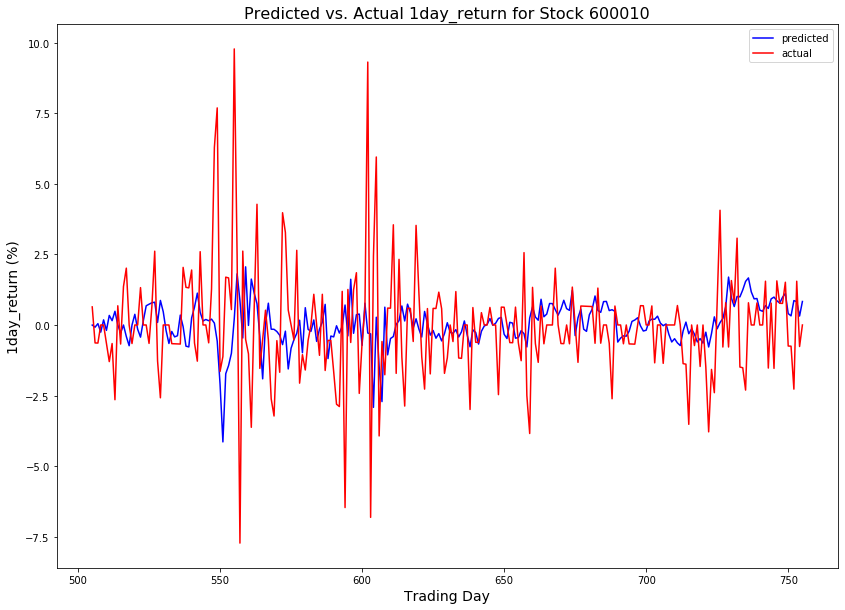

In [21]:
#plotting predicted return with real return for second stock

fig = plt.figure(figsize=(14,10))

plt.plot(trade_data[stock_files[1]].loc[:,'day'], trade_data[stock_files[1]].loc[:,'est_1day_return_lag'], color='b', label='predicted')
plt.plot(trade_data[stock_files[1]].loc[:,'day'], trade_data[stock_files[1]].loc[:,'1day_return_lag'], color='r', label='actual')
plt.title('Predicted vs. Actual 1day_return for Stock 600010', fontsize=16)
plt.xlabel('Trading Day', fontsize=14)
plt.ylabel('1day_return (%)', fontsize=14)

plt.legend()
plt.show()
fig.savefig('predictedVSactual.png')

## Final Results

In [303]:
# Testing Function over many days and returning cash
# Best Thresholds for now:
# threshold = 0.02
# sell_thresh = -0.05
cash = 1000000
increment = 1000000/10
holding = {stock: 0 for stock in stock_files}
cost = 0.065
total_assets = []
threshold = 2.00
sell_thresh = -1.00
#day = 0
#cash, holding = trade(day, cash, increment, threshold, trade_data, holding, cost)
#trade(day, cash, increment, threshold, trade_data, holding, cost)
#  Testing function over many days

totalDays = len(trade_data[stock_files[0]])
for day in range(0, totalDays-1):
    cash, holding = trade(day, cash, increment, threshold, 
                          trade_data, holding, cost, sell_thresh)
    assets = cash

    for stock, shares in holding.items():
        price = trade_data[stock].loc[day, 'close']
        assets += price*shares

    total_assets.append(assets)

    #print('day ', day, ':  ', cash)
# print(cash)
# print(holding)

for stock, shares in holding.items():
    price = trade_data[stock].loc[totalDays - 1, 'close']
    cash += price*shares* (1-cost/100)
    holding[stock] = 0
total_assets.append(cash)
print(f'Total cash: {cash:.2f}')
#print(total_assets)

Total cash: 1033540.14


In [304]:
# getting of days with profit and sharpe ratio
pnl_list = []
for i in range(1, len(total_assets)):
    pnl = (total_assets[i]/total_assets[i-1]) - 1
    pnl_list.append(pnl)
#print(pnl_list[:15])
pnl_arr = np.array(pnl_list)
sharpe = (np.sqrt(252) * pnl_arr.mean())/(pnl_arr.std())
profitable_days = np.sum(pnl_arr>0)
print(f'Sharpe Ratio:\t\t{sharpe:.4f}')
print(f'Total Profitable days:\t{profitable_days}')

Sharpe Ratio:		0.3568
Total Profitable days:	115


In [305]:
# Testing Function 
#cash = 1000000
#print(cash)
#holding = {stock: 0 for stock in stock_files}
#trade(0, cash, increment, threshold, trade_data, holding, cost)
#print(cash)
#print(holding)

In [306]:
# Getting Statistical Metrics for each dataframe
R2 = []
MAPE = []
RMSE = []
for df in trade_data.values():
    r2 = r2_score(df['1day_return_lag'][:-2], df['est_1day_return_lag'][:-2])
    rmse = np.sqrt(mean_squared_error(df['1day_return_lag'][:-2], df['est_1day_return_lag'][:-2]))
    mape = get_mape(df['1day_return_lag'][:-2], df['est_1day_return_lag'][:-2])
    R2.append(r2); RMSE.append(rmse); MAPE.append(mape)
print(f'Mean Test R-Squared:\t{(sum(R2)/len(R2)):.4f}')
print(f'Mean Test RMSE:\t\t{(sum(RMSE)/len(RMSE)):.4f}')
print(f'Mean Test MAPE:\t\t{(sum(MAPE)/len(MAPE)):.4f}')

Mean Test R-Squared:	-0.1543
Mean Test RMSE:		1.8937
Mean Test MAPE:		inf


C:\Users\donny\Anaconda3\lib\site-packages\ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\donny\Anaconda3\lib\site-packages\ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\donny\Anaconda3\lib\site-packages\ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\donny\Anaconda3\lib\site-packages\ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\donny\Anaconda3\lib\site-packages\ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\donny\Anaconda3\lib\site-packages\ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\donny\Anaconda3\lib\site-packages\ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\donny\Anaconda3\lib\site-packages\ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered

## Further Exploration

In [141]:
# # A function to get the best training period for each stock 
# # Redefining to change the test set
# def get_best_N(mapeList, threshold = 0.03): 
#     '''
#     inputs
#     mapeList : a list of mean absolute percentage errors, index 0 is where N = 2
#     threshold : the threshold for how close the mape must be for N to be considered
#     outputs:
#     bestN : the maximum N that generates a mape as close as possible to the minimum
#     '''
#     min_mape = min(mapeList)
#     best_N = mapeList.index(min_mape) + 2
#     return(best_N)

In [367]:
# # Creating New Dictionary of dataframes
# trade_data2 = {}
# for file in stock_files:
#     trade_data2[file] = predictor(stock_data[file])
# trade_data2[stock_files[0]].head()

In [20]:
# # Getting Statistical Metrics for each dataframe
# # (New Predictions for Test)
# R2 = []
# MAPE = []
# RMSE = []
# for df in trade_data2.values():
#     r2 = r2_score(df['close'], df['pred'])
#     rmse = np.sqrt(mean_squared_error(df['close'], df['pred'],))
#     mape = get_mape(df['close'], df['pred'])
#     R2.append(r2); RMSE.append(rmse); MAPE.append(mape)
# print(f'Mean Test R-Squared:\t{(sum(R2)/len(R2)):.4f}')
# print(f'Mean Test RMSE:\t\t{(sum(RMSE)/len(RMSE)):.4f}')
# print(f'Mean Test MAPE:\t\t{(sum(MAPE)/len(MAPE)):.4f}')

In [21]:
# # Testing Function over many days and returning cash
# # Best Thresholds for now:
# # threshold = 0.02
# # sell_thresh = -0.05
# cash = 1000000
# increment = 20000
# holding = {stock: 0 for stock in stock_files}
# cost = 0.00065
# total_assets = []
# threshold = 0.02
# sell_thresh = -0.04
# #  Testing function over many days
# totalDays = len(trade_data2[stock_files[0]])
# for threshold in [0.02, 0.03, 0.04]:
#     for sell_thresh in [-0.05, -0.04, -0.03, 0.02, -0.01, 0, 0.01]:
#         cash = 1000000
#         print(cash)
#         for day in range(0, totalDays-1):
#             cash, holding = trade(day, cash, increment, threshold, 
#                                   trade_data2, holding, cost, sell_thresh)
#             assets = cash
#             for stock, shares in holding.items():
#                 price = trade_data2[stock].loc[day, 'close']
#                 assets += price*shares
#             total_assets.append(assets)
#         # Selling off at end
#         for stock, shares in holding.items():
#             price = trade_data2[stock].loc[totalDays - 1, 'close']
#             cash += price*shares* (1-cost)
#             holding[stock] = 0
#         total_assets.append(cash)
#         print(f'Buy: {threshold}\t Sell: {sell_thresh}')
#         print(f'Total cash: {cash:.2f}')

In [55]:
# Testing Function over many days and returning cash
# Testing wth new thresholds
# Best Thresholds for now:
# threshold = 0.02
# sell_thresh = -0.05
cash = 1000000
increment = 5000
holding = {stock: 0 for stock in stock_files}
#cost = 0.00065
cost = 0
total_assets = []
threshold = 0.04
sell_thresh = -0.02
#  Testing function over many days
totalDays = len(trade_data[stock_files[0]])
for day in range(0, totalDays-1):
    cash, holding = trade(day, cash, increment, threshold, 
                          trade_data, holding, cost, sell_thresh)
    assets = cash
    for stock, shares in holding.items():
        price = trade_data[stock].loc[day, 'close']
        assets += price*shares
    total_assets.append(assets)
# Selling off at end
for stock, shares in holding.items():
    price = trade_data[stock].loc[totalDays - 1, 'close']
    cash += price*shares* (1-cost)
    holding[stock] = 0
total_assets.append(cash)
print(f'Buy: {threshold}\t Sell: {sell_thresh}')
print(f'Total cash: {cash:.2f}')

Buy: 0.04	 Sell: -0.02
Total cash: 996463.68


In [49]:
# getting of days with profit and sharpe ratio
pnl_list = []
for i in range(1, len(total_assets)):
    pnl = (total_assets[i]/total_assets[i-1]) - 1
    pnl_list.append(pnl)
#print(pnl_list[:15])
pnl_arr = np.array(pnl_list)
sharpe = (np.sqrt(252) * pnl_arr.mean())/(pnl_arr.std())
profitable_days = np.sum(pnl_arr>0)
print(f'Sharpe Ratio:\t\t{sharpe:.4f}')
print(f'Total Profitable days:\t{profitable_days}')

Sharpe Ratio:		-0.4364
Total Profitable days:	94
